In [47]:
import csv
import pickle
from datetime import date, datetime, timedelta
import numpy as np
import math
import copy
from operator import itemgetter
import matplotlib.pyplot as plt

## Convert row ftse file data to pickle

In [19]:
# ToDo: move all methods to a separate file and import them

def convert_txt_to_dict(filename):
    content = []

    with open(filename, newline='') as f:
        reader = csv.reader(f)
        for row in reader:
            content.append(row)

    data_ftse_100_dict = {}
    tickers_list = [ticker[:-2] for ticker in content[0][1:]]
    data_ftse_100_dict = {}

    for row in content[1:]:
        data_ftse_100_dict[row[0]] = {}
        for i, ticker in enumerate(tickers_list):
            data_ftse_100_dict[row[0]][ticker] = row[i + 1]
    return data_ftse_100_dict

    
txt_filename = 'ftse_100_time_data.csv'
path_to_save = "./data_ftse_interp_0_1_2001_2006.p"

data_ftse_100_dict = convert_txt_to_dict(txt_filename)

# pickle.dump(data_ftse_100_dict, open(path_to_save, "wb"))

## Library to interpolate ftse dataset

How to write `add_dates` method
http://stackoverflow.com/questions/3240458/how-to-increment-the-day-in-datetime-python

In [20]:
def datetime_to_date(datetime_date):
    datetime_date.date().year
    str_date = '{}-{}-{}'.format(datetime_date.date().strftime('%Y'), datetime_date.date().strftime('%m'), datetime_date.date().strftime('%d'))
    return str_date
    
def date_to_datetime(date):
    return datetime.strptime(date, '%Y-%m-%d')

def find_start_end_dates(ticker, dates_dict):
    # this method looks when a company started to be in ftse 100. Assume that some dates may not have dictionaries
    # with ticker. No ticker in keys.
    start = ""
    end = ""
    for date, stock_values in dates_dict.items():
        if ticker in stock_values.keys():
            if stock_values[ticker]:
                # check if start is empty
                if not start:
                    start = date
                else:
                    end = date
    
    return start, end # dates in datetime format

def get_dates_range(start_date, end_date):
    # assume start_date and end_date are in datetime format
    dates_range = []
    delta = end_date - start_date
    date_index = start_date
    for i in range(delta.days + 1):
        dates_range.append(date_index)
        date_index += timedelta(days=1)
    return dates_range

def add_interpolated_values(dates_range, ticker, dates_dict):
    modified_dates_dict = dates_dict
    start_indicator = dates_range[0]
    end_indicator = dates_range[-1]
    interpolated_value = (float(modified_dates_dict[datetime_to_date(start_indicator)][ticker]) + float(modified_dates_dict[datetime_to_date(end_indicator)][ticker])) / 2
    for date in dates_range[1:-1]:
        # Initialise new date
        try:
            value = modified_dates_dict[datetime_to_date(date)]
        except KeyError:
            modified_dates_dict[datetime_to_date(date)] = {}
        
        modified_dates_dict[datetime_to_date(date)][ticker] = interpolated_value

    return modified_dates_dict # add average values using start_indicator and end_indicator
    
def add_missing_date(missing_date, complete_dates_dict, ticker):
    #print("here")
    #print(len(list(complete_dates_dict.keys())))
    try:
        dic = complete_dates_dict[missing_date]
        try:
            value = complete_dates_dict[missing_date][ticker]
        except KeyError:
            complete_dates_dict[missing_date][ticker] = ""
    except KeyError:
        complete_dates_dict[missing_date] = {}
        complete_dates_dict[missing_date][ticker] = ""

def initialize_date(date_init, all_dates_dict, ticker, initial_value):
    if not all_dates_dict[datetime_to_date(date_init)][ticker]:
        all_dates_dict[datetime_to_date(date_init)][ticker] = initial_value

def interpolate(dates_dict, ticker, start_date, end_date):
    # assume start_date and end_date are in datetime format
    dates_range = get_dates_range(start_date, end_date)
    start_indicator = dates_range[0]
    dates_dict_interp = dates_dict
    
    add_missing_date(datetime_to_date(start_indicator), dates_dict_interp, ticker)
    initialize_date(start_indicator, dates_dict_interp, ticker, 500)
    
    for date in dates_range[1:]:
        add_missing_date(datetime_to_date(date), dates_dict_interp, ticker)
        #print("start", datetime_to_date(start_indicator))
        #print("end", datetime_to_date(end_indicator))
        #print("date", datetime_to_date(date))
        #print("ticker_value", dates_dict_interp[datetime_to_date(date)][ticker])
        #print(dates_dict_interp[datetime_to_date(date)][ticker])
        if dates_dict_interp[datetime_to_date(date)][ticker]:
            #print(dates_dict_interp[datetime_to_date(date)][ticker])
            #print(datetime_to_date(date))
            #print("empty")
            if (date - start_indicator).days >= 1:
                dates_range_interp = get_dates_range(start_indicator, date)
                dates_dict_interp = add_interpolated_values(dates_range_interp, ticker, dates_dict_interp)
                start_indicator = date
            else:
                start_indicator = date
            
    return dates_dict_interp

def get_existing_companies(date_point, data_ftse_100):
    tickers_list = list(data_ftse_100['2012-07-11'].keys())
    valid_tickers = []
    for ticker in tickers_list:
        start, end = find_start_end_dates(ticker, data_ftse_100)
        if date_to_datetime(date_point) > date_to_datetime(start):
            valid_tickers.append(ticker)
    return valid_tickers

def interpolate_all(tickers_lst, data_ftse, date_init, date_end):
    data_ftse_100_dict_interp = copy.deepcopy(data_ftse) 
    for ticker in tickers_lst:
        data_ftse_100_dict_interp = interpolate(data_ftse_100_dict_interp, ticker, date_to_datetime(date_init), date_to_datetime(date_end))
    
    return data_ftse_100_dict_interp

In [21]:
start, end = find_start_end_dates("III", data_ftse_100_dict)
print(start, end)

1993-03-31 2015-04-29


## Calculate correlations

In [23]:
def get_components_matrix(time_window, time_start, time_end, ticker_list, dates_dict):
    components_distance = {}
    dates_range = get_dates_range(date_to_datetime(time_start), date_to_datetime(time_end))
    
    for date in dates_range:
        vectors = []
        for ticker in ticker_list:
            vectors.append(get_s_vector(time_window, ticker, dates_dict, date))
        components_distance[datetime_to_date(date)] = np.corrcoef(vectors)
    return components_distance # dict where each key is time and value is distance

def get_s_vector(time_window, ticker, dates_dict, initial_time):
    s_vector = []
    end_time = initial_time + timedelta(days=time_window)
    dates_window = get_dates_range(initial_time, end_time)
    for date in dates_window:
        s_vector.append(get_s(date, ticker, dates_dict))
    return s_vector

def get_s(time, ticker, dates_dict):
    s = np.log(float(dates_dict[datetime_to_date(time + timedelta(days=1))][ticker])) - np.log(float(dates_dict[datetime_to_date(time)][ticker]))
    return s

#ticker_1 = valid_tickers[5:][0]
#ticker_2 = valid_tickers[5:7][1]  
#ticker_1 = "ARM"
#ticker_2 = "ANTO" 
#print(np.log(float(data_ftse_100_dict_interp[datetime_to_date(date_to_datetime('2013-04-01') + timedelta(days=1))][ticker])))
#dist = get_components_matrix(45, '2012-07-13', '2013-07-15', valid_tickers[0:4], data_ftse_interp)
#print(dist['2012-07-13'])
# numpy.corrcoef

## Build graph

In [13]:
import igraph

def edges_vector(tickers, matrix):
    edges = []
    edges_values = []
    for i, tick_i in enumerate(tickers):
        for j, tick_j in enumerate(tickers):
            if j != i:
                edges.append((i, j))
                edges_values.append(matrix[i][j])
                
    return edges, edges_values

def create_graph(tickers, matrix):
    edges_lst, edges_corr = edges_vector(tickers, matrix)
    g = igraph.Graph(edges_lst)
    g.vs["tickers"] = tickers
    g.es["correlation"] = edges_corr
    
    return g
    
g_res = create_graph(valid_tickers[0:4], dist['2012-07-13'])
    
g_res.summary()

NameError: name 'valid_tickers' is not defined

## Build MST

In [14]:
"""
print(g_res.es["correlation"])
mst = g_res.spanning_tree(weights=g_res.es["correlation"])
mst.summary()

print(mst.vs["tickers"])

print(mst.es["correlation"])

for e in mst.es:
    print(e.tuple)
    
mst.degree()
"""

NameError: name 'g_res' is not defined

What I want to get in an output? For each company I would like to get degree of vertice as a function of time. 

In [24]:
def calculate_degree_distribution(window_size, start_date, end_date, dataset_init):
    degrees_dict = {}
    
    valid_tickers = get_existing_companies(start_date, dataset_init)
    
    data_ftse_interp = interpolate_all(valid_tickers, dataset_init, start_date, end_date)
    
    end_date_datetime_win = date_to_datetime(end_date) - timedelta(days=window_size+1)
    end_date_win = datetime_to_date(end_date_datetime_win)
    
    dist_corr = get_components_matrix(window_size, start_date, end_date_win, valid_tickers, data_ftse_interp)
    
    for date_corr in dist_corr.keys():
        g_res = create_graph(valid_tickers, dist_corr[date_corr])
        mst = g_res.spanning_tree(weights=g_res.es["correlation"])
        degrees_dict[date_corr] = mst.degree()
        
    return degrees_dict
        
deg_dict = calculate_degree_distribution(360, '2010-07-14', '2011-10-11', data_ftse_100_dict)

In [32]:
tic_degree = {}
valid_tickers = get_existing_companies('2010-10-15', data_ftse_100_dict)

for i, degree in enumerate(deg_dict['2010-10-15']):
    tic_degree[valid_tickers[i]] = [degree]
    
print(tic_degree)

{'AAL': [1], 'ABF': [1], 'ADM': [1], 'ADN': [1], 'AGK': [1], 'AHT': [1], 'ANTO': [1], 'ARM': [1], 'AV': [1], 'AZN': [1], 'BA': [1], 'BAB': [1], 'BARC': [1], 'BATS': [1], 'BDEV': [1], 'BG': [1], 'BLND': [1], 'BLT': [1], 'BNZL': [1], 'BP': [1], 'BRBY': [1], 'BT-A': [1], 'CCL': [1], 'CNA': [1], 'CPG': [1], 'CPI': [1], 'CRH': [1], 'DC': [1], 'DGE': [1], 'EXPN': [1], 'EZJ': [1], 'FRES': [1], 'GFS': [1], 'GKN': [1], 'GSK': [1], 'HIK': [1], 'HL': [1], 'HMSO': [1], 'HSBA': [1], 'IAG': [1], 'IHG': [1], 'III': [46], 'IMT': [1], 'INTU': [1], 'ITRK': [1], 'ITV': [1], 'JMAT': [1], 'KGF': [1], 'LAND': [1], 'LGEN': [1], 'LLOY': [1], 'LSE': [1], 'MGGT': [1], 'MKS': [1], 'MNDI': [1], 'MRW': [1], 'NG': [1], 'NXT': [1], 'OML': [1], 'PRU': [1], 'PSN': [1], 'PSON': [1], 'RB': [1], 'RBS': [1], 'RDSA': [1], 'RDSB': [1], 'REL': [1], 'RIO': [1], 'RR': [1], 'RRS': [48], 'RSA': [1], 'SAB': [1], 'SBRY': [1], 'SDR': [1], 'SGE': [1], 'SHP': [1], 'SKY': [1], 'SL': [1], 'SMIN': [1], 'SN': [1], 'SPD': [2], 'SSE': [1],

**Notes:** Randgold is in the center of the graph. 

In [27]:
len(valid_tickers)

95

In [28]:
deg_dict_2 = calculate_degree_distribution(360, '2012-07-14', '2013-10-11', data_ftse_100_dict)

In [35]:
tic_degree_2 = {}
valid_tickers_2 = get_existing_companies('2012-07-14', data_ftse_100_dict)

for i, degree in enumerate(deg_dict_2['2012-07-26']):
    tic_degree_2[valid_tickers_2[i]] = [degree]
    
print(tic_degree_2)


{'AAL': [1], 'ABF': [1], 'ADM': [1], 'ADN': [1], 'AGK': [2], 'AHT': [1], 'ANTO': [1], 'ARM': [1], 'AV': [1], 'AZN': [1], 'BA': [1], 'BAB': [1], 'BARC': [1], 'BATS': [1], 'BDEV': [1], 'BG': [1], 'BLND': [1], 'BLT': [1], 'BNZL': [1], 'BP': [1], 'BRBY': [1], 'BT-A': [1], 'CCL': [1], 'CNA': [1], 'CPG': [1], 'CPI': [1], 'CRH': [1], 'DC': [1], 'DGE': [1], 'EXPN': [1], 'EZJ': [1], 'FRES': [1], 'GFS': [1], 'GKN': [1], 'GLEN': [1], 'GSK': [2], 'HIK': [1], 'HL': [1], 'HMSO': [1], 'HSBA': [1], 'IAG': [1], 'IHG': [1], 'III': [1], 'IMT': [1], 'INTU': [1], 'ITRK': [1], 'ITV': [1], 'JMAT': [1], 'KGF': [1], 'LAND': [1], 'LGEN': [1], 'LLOY': [1], 'LSE': [1], 'MGGT': [1], 'MKS': [1], 'MNDI': [1], 'MRW': [1], 'NG': [1], 'NXT': [1], 'OML': [1], 'PRU': [1], 'PSN': [1], 'PSON': [1], 'RB': [1], 'RBS': [1], 'RDSA': [1], 'RDSB': [1], 'REL': [1], 'RIO': [1], 'RR': [92], 'RRS': [2], 'RSA': [1], 'SAB': [1], 'SBRY': [1], 'SDR': [1], 'SGE': [1], 'SHP': [1], 'SKY': [1], 'SL': [1], 'SMIN': [1], 'SN': [1], 'SPD': [1],

**Notes:** Royce Royce in the center of the graph. 

### Histograms of vertex degrees for industries

In [2]:
lines = [line.rstrip('\n') for line in open('./tickers_sectors.csv')]

In [38]:
ticker_industry = []
for line in lines:
    line_list = line.split(",")
    ticker_industry.append([line_list[1], line_list[2]])


In [41]:
for element in ticker_industry:
    try:
        tic_degree_2[element[0]].append(element[1])
    except:
        pass

print(tic_degree_2)

{'AAL': [1, 'Mining'], 'ABF': [1, 'Food'], 'ADM': [1, 'Insurance'], 'ADN': [1, 'Fund management'], 'AGK': [2], 'AHT': [1, 'Equipment rental'], 'ANTO': [1, 'Mining'], 'ARM': [1, 'Engineering'], 'AV': [1], 'AZN': [1, 'Pharmaceuticals'], 'BA': [1], 'BAB': [1, 'Engineering'], 'BARC': [1, 'Banking'], 'BATS': [1, 'Tobacco'], 'BDEV': [1, 'Building'], 'BG': [1], 'BLND': [1, 'Property'], 'BLT': [1, 'Mining'], 'BNZL': [1, 'Industrial products'], 'BP': [1, 'Oil and gas'], 'BRBY': [1, 'Fashion'], 'BT-A': [1], 'CCL': [1, 'Leisure'], 'CNA': [1, 'Energy'], 'CPG': [1, 'Food'], 'CPI': [1, 'Support Services'], 'CRH': [1, 'Building materials'], 'DC': [1], 'DGE': [1, 'Beverages'], 'EXPN': [1, 'Information'], 'EZJ': [1, 'Travel'], 'FRES': [1, 'Mining'], 'GFS': [1], 'GKN': [1, 'Manufacturing'], 'GLEN': [1, 'Mining'], 'GSK': [2, 'Pharmaceuticals'], 'HIK': [1, 'Manufacturing'], 'HL': [1, 'Finance'], 'HMSO': [1, 'Property'], 'HSBA': [1, 'Banking'], 'IAG': [1, 'Travel'], 'IHG': [1, 'Hotels'], 'III': [1, 'Privat

In [44]:
industries_dupl = []
for ticker in tic_degree_2.keys():
    if len(tic_degree_2[ticker]) > 1:
        industries_dupl.append(tic_degree_2[ticker][1])
industries = list(set(industries_dupl))
print(industries)

['Education', 'Retail clothing', 'IT', 'Engineering', 'Consumer goods', 'Support Services', 'Beverages', 'Publishing', 'Building', 'Fashion', 'Travel', 'Oil and gas', 'Information', 'Retail', 'Supermarket', 'Hotels', 'Food', 'Equipment rental', 'Retail homeware', 'Pharmaceuticals', 'Banking', 'Fund management', 'Property', 'Retailer', 'Chemicals', 'Energy', 'Tobacco', 'Leisure', 'Finance', 'Manufacturing', 'Mining', 'Building materials', 'Product testing', 'Media', 'Retail hospitality', 'Industrial products', 'Insurance', 'Telecomms', 'Private equity', 'Water']


In [46]:
tic_degree_2["RR"] = [92, "Manufacturing"]

industries_tickers = {}
for industry in industries:
    industries_tickers[industry] = []
    for ticker in tic_degree_2.keys():
        if len(tic_degree_2[ticker]) > 1:
            if tic_degree_2[ticker][1] == industry:
                industries_tickers[industry].append([ticker, tic_degree_2[ticker][0]])
                
print(industries_tickers)

{'Education': [['PSON', 1]], 'Retail clothing': [['NXT', 1]], 'IT': [['SGE', 1]], 'Engineering': [['ARM', 1], ['BAB', 1], ['SMIN', 1]], 'Consumer goods': [['RB', 1], ['ULVR', 1]], 'Support Services': [['CPI', 1]], 'Beverages': [['DGE', 1], ['SAB', 1]], 'Publishing': [['REL', 1]], 'Building': [['BDEV', 1], ['PSN', 1]], 'Fashion': [['BRBY', 1]], 'Travel': [['EZJ', 1], ['IAG', 1]], 'Oil and gas': [['BP', 1], ['RDSA', 1]], 'Information': [['EXPN', 1]], 'Retail': [['SPD', 1]], 'Supermarket': [['SBRY', 1], ['TSCO', 1]], 'Hotels': [['IHG', 1]], 'Food': [['ABF', 1], ['CPG', 1]], 'Equipment rental': [['AHT', 1]], 'Retail homeware': [['KGF', 1]], 'Pharmaceuticals': [['AZN', 1], ['GSK', 2], ['SHP', 1]], 'Banking': [['BARC', 1], ['HSBA', 1], ['LLOY', 1], ['RBS', 1], ['STAN', 1]], 'Fund management': [['ADN', 1], ['SDR', 1], ['SL', 1]], 'Property': [['BLND', 1], ['HMSO', 1], ['INTU', 1], ['LAND', 1]], 'Retailer': [['MKS', 1], ['TPK', 1]], 'Chemicals': [['JMAT', 1]], 'Energy': [['CNA', 1], ['NG', 1],

Education


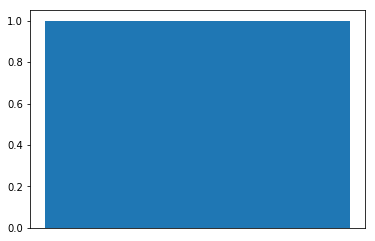

Retail clothing


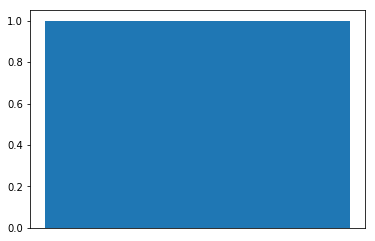

IT


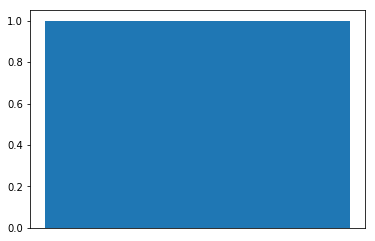

Engineering


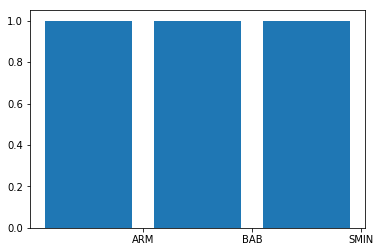

Consumer goods


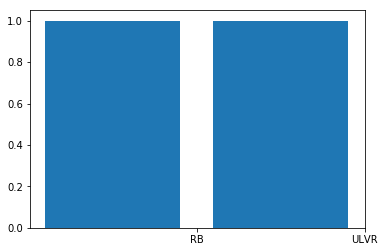

Support Services


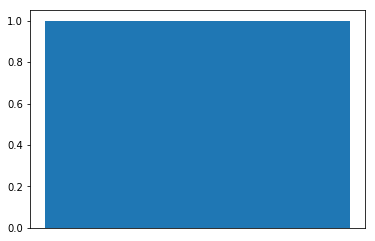

Beverages


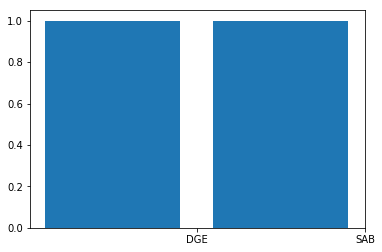

Publishing


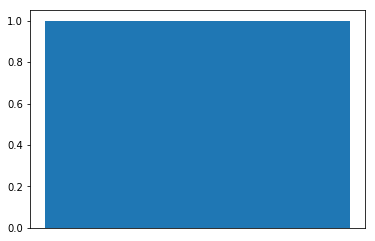

Building


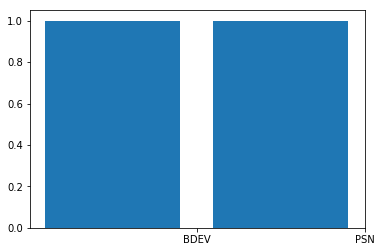

Fashion


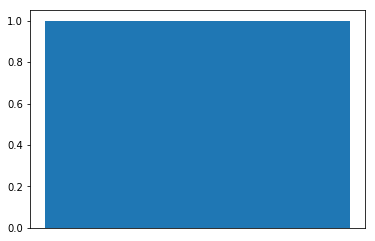

Travel


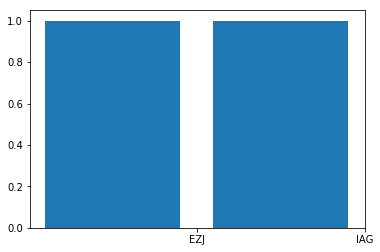

Oil and gas


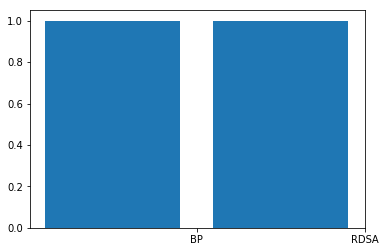

Information


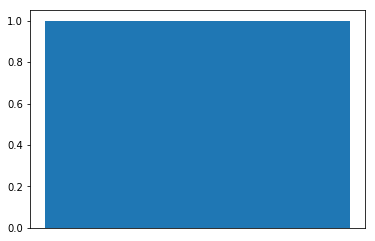

Retail


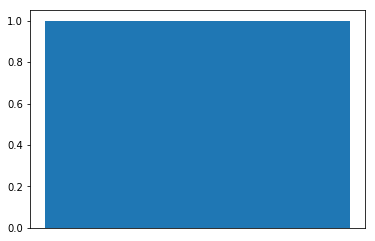

Supermarket


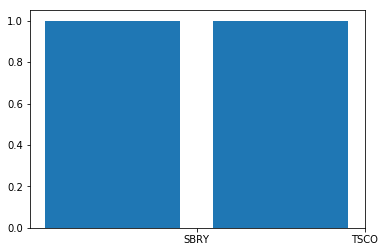

Hotels


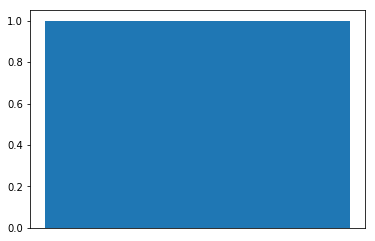

Food


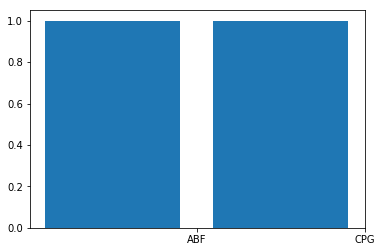

Equipment rental


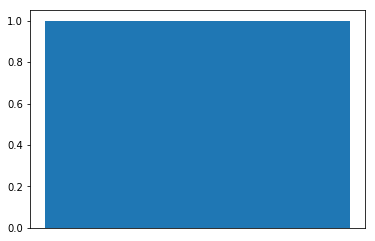

Retail homeware


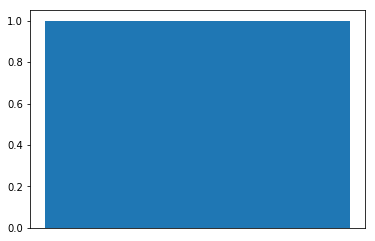

Pharmaceuticals


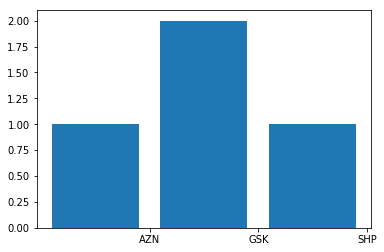

Banking


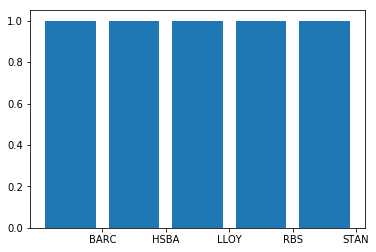

Fund management


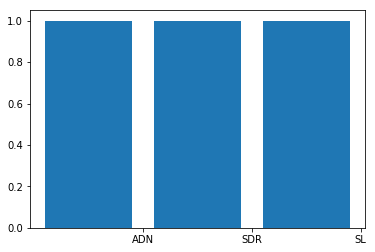

Property


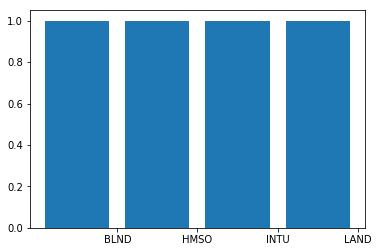

Retailer


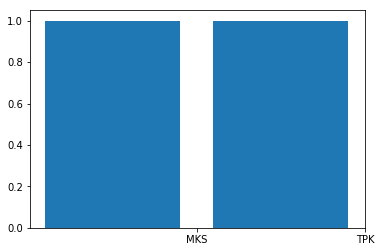

Chemicals


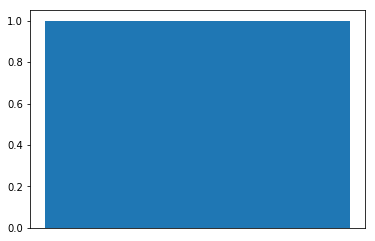

Energy


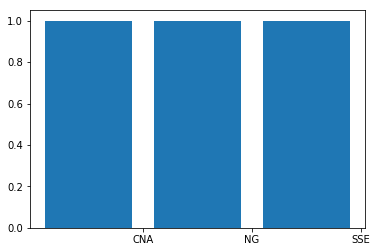

Tobacco


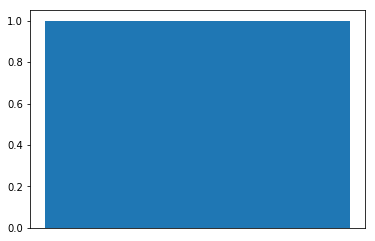

Leisure


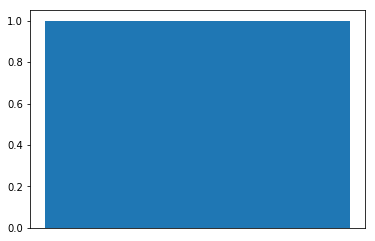

Finance


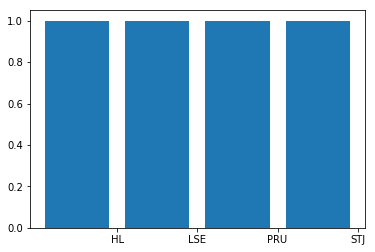

Manufacturing


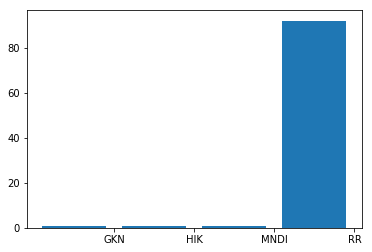

Mining


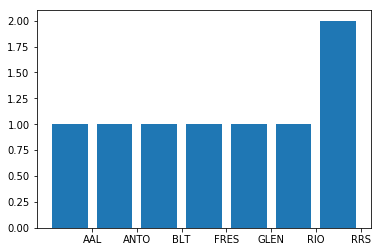

Building materials


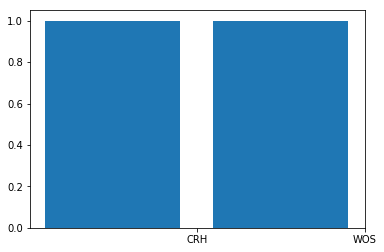

Product testing


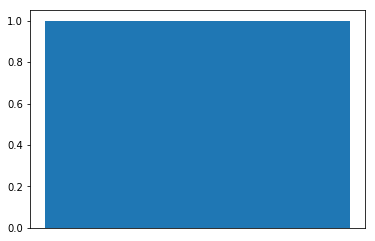

Media


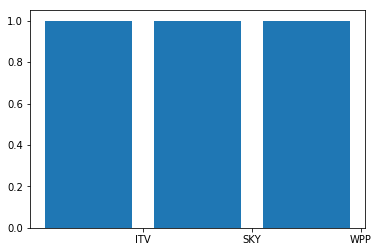

Retail hospitality


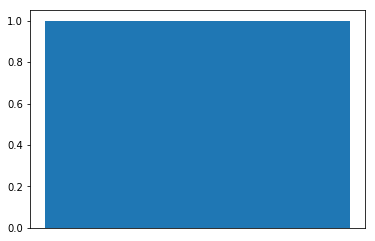

Industrial products


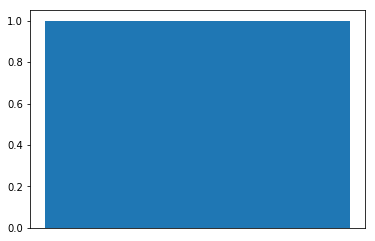

Insurance


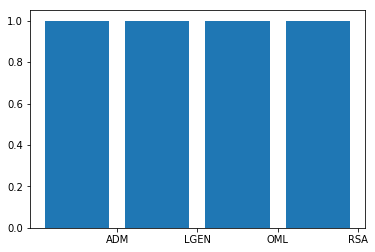

Telecomms


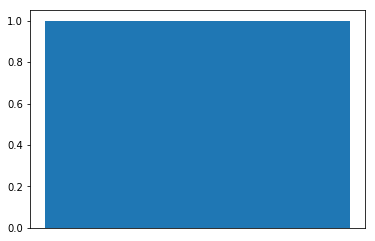

Private equity


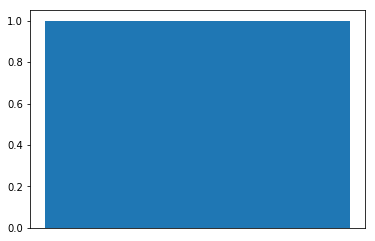

Water


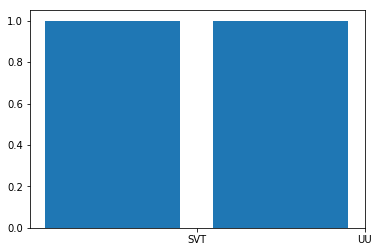

In [49]:
for industry in industries_tickers.keys():
    labels = []
    degrees = []
    for element in industries_tickers[industry]:
        labels.append(element[0])
        degrees.append(element[1])
        
    x = np.arange(len(degrees))
    print(industry)
    plt.bar(x, height = degrees)
    plt.xticks(x+.5, labels)
    plt.show()
        